<a href="https://colab.research.google.com/github/AabidMK/RealtyAI_Infosys_Internship_Aug2025/blob/Kalluri_Gayathri/Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#importing libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Load dataset
df = pd.read_csv("Real Estate Data V21.csv")

In [3]:
#Provides No.of rows and Cols
df.shape
#In the output there are 14528 Rows and 9 Coumns

(14528, 9)

In [4]:
# View first 5 rows
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes


In [5]:
#Name of Attributes/Colums present in the dataset
df.columns

Index(['Name', 'Property Title', 'Price', 'Location', 'Total_Area',
       'Price_per_SQFT', 'Description', 'Baths', 'Balcony'],
      dtype='object')

In [6]:
#datatypes of each Attribute
df.dtypes

,0
Name,object
Property Title,object
Price,object
Location,object
Total_Area,int64
Price_per_SQFT,float64
Description,object
Baths,int64
Balcony,object


In [7]:
#Summary statistics for numerical columns
df.describe()

,Total_Area,Price_per_SQFT,Baths
count,14528.000000,14528.000000,14528.000000
mean,1297.916988,11719.456222,2.751239
std,1245.694305,49036.068632,0.898243
min,70.000000,0.000000,1.000000
25%,650.000000,4480.000000,2.000000
50%,1000.000000,6050.000000,3.000000
75%,1439.000000,9312.500000,3.000000
max,35000.000000,999000.000000,6.000000


In [8]:
#Finding out Missing values
df.isnull().sum()

,0
Name,0
Property Title,0
Price,0
Location,0
Total_Area,0
Price_per_SQFT,0
Description,0
Baths,0
Balcony,0


In [9]:
# Clean Price Column
import re
def clean_price(price_str):
    price_str = str(price_str).replace("₹", "").strip()
    if "Cr" in price_str:  # Crores
        return float(re.sub("[^0-9.]", "", price_str)) * 1e7
    elif "L" in price_str:  # Lakhs
        return float(re.sub("[^0-9.]", "", price_str)) * 1e5
    else:  # Plain number
        return float(re.sub("[^0-9.]", "", price_str))

df["Price_Cleaned"] = df["Price"].apply(clean_price)

In [10]:
# Clean Balcony Column
def clean_balcony(value):
    if str(value).strip().lower() == "yes":
        return 1
    else:
        return 0

df["Balcony_Cleaned"] = df["Balcony"].apply(clean_balcony)

In [11]:
# Extract BHK
import re
def extract_bhk(title):
    match = re.search(r"(\d+)\s*BHK", str(title))
    if match:
        return int(match.group(1))
    return None

df["BHK"] = df["Property Title"].apply(extract_bhk)

In [12]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Price_Cleaned,Balcony_Cleaned,BHK
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,19900000.0,1,4.0
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,22500000.0,1,10.0
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,10000000.0,0,3.0
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,33300000.0,1,7.0
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes,4800000.0,1,2.0


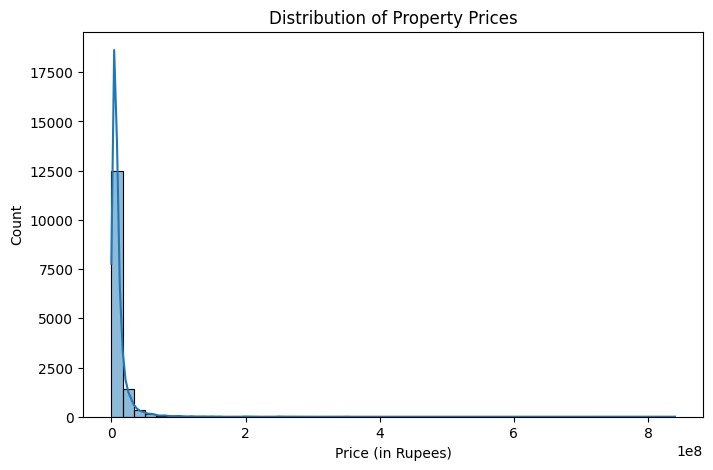

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Price_Cleaned"], bins=50, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price (in Rupees)")
plt.ylabel("Count")
plt.show()

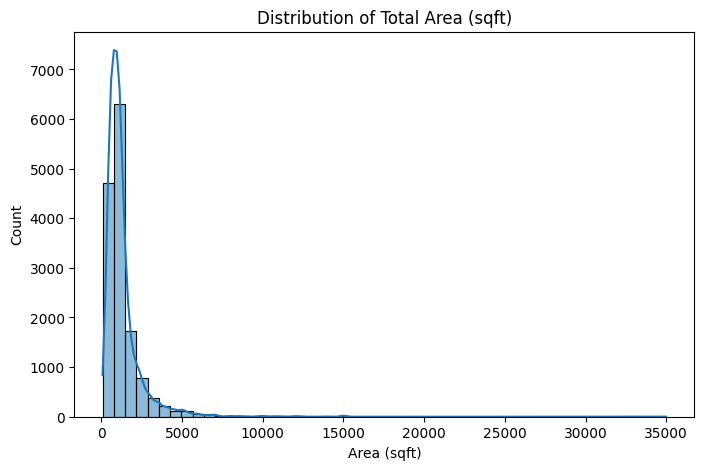

In [14]:
# Total Area distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Total_Area"], bins=50, kde=True)
plt.title("Distribution of Total Area (sqft)")
plt.xlabel("Area (sqft)")
plt.ylabel("Count")
plt.show()

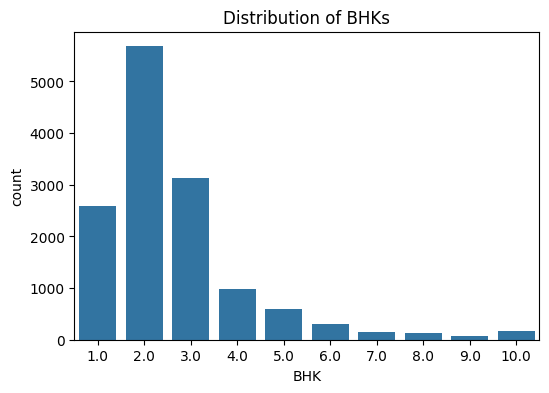

In [15]:
# BHK distribution
plt.figure(figsize=(6,4))
sns.countplot(x="BHK", data=df)
plt.title("Distribution of BHKs")
plt.show()

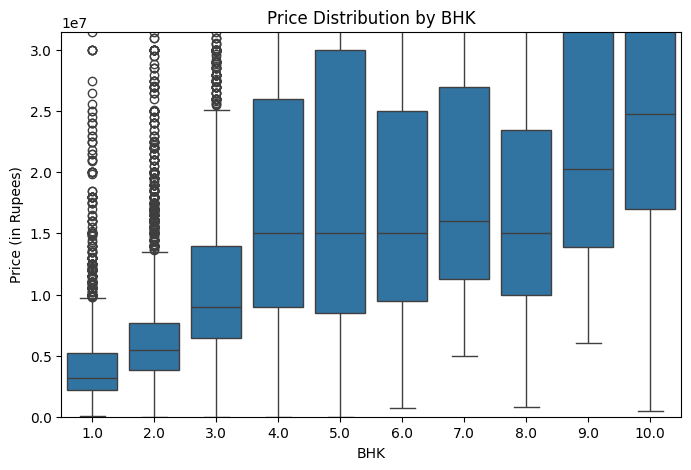

In [16]:
# Price vs BHK
plt.figure(figsize=(8,5))
sns.boxplot(x="BHK", y="Price_Cleaned", data=df)
plt.title("Price Distribution by BHK")
plt.xlabel("BHK")
plt.ylabel("Price (in Rupees)")
plt.ylim(0, df["Price_Cleaned"].quantile(0.95))  # remove extreme outliers
plt.show()

/tmp/ipython-input-988495468.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")


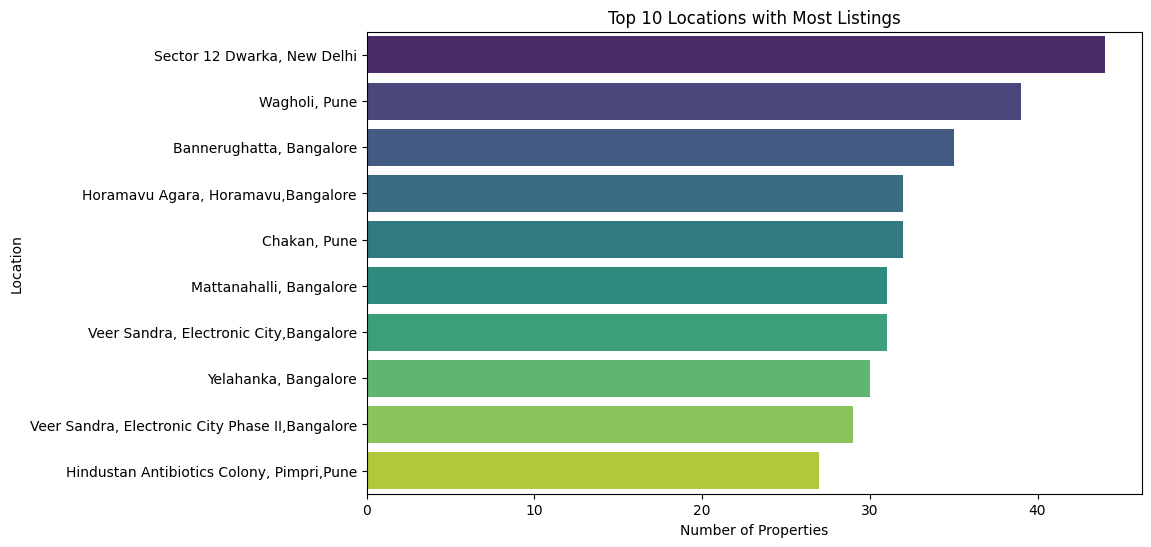

In [17]:
#Top 10 Locations with most properties
top_locations = df["Location"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("Top 10 Locations with Most Listings")
plt.xlabel("Number of Properties")
plt.ylabel("Location")
plt.show()

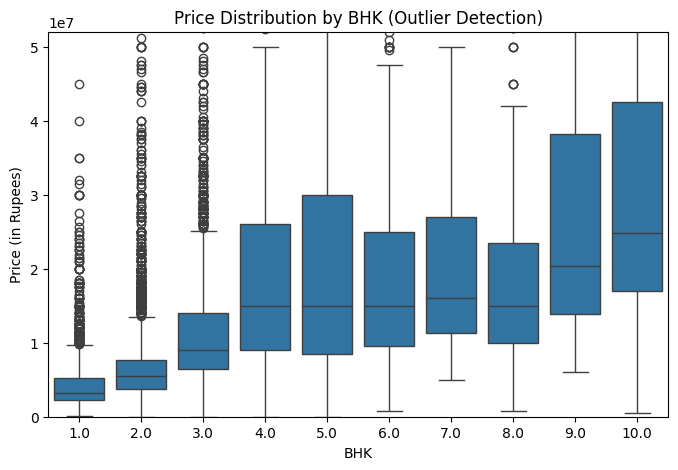

In [18]:
#Outlier Detection (Price vs Area)
plt.figure(figsize=(8,5))
sns.boxplot(x="BHK", y="Price_Cleaned", data=df)
plt.title("Price Distribution by BHK (Outlier Detection)")
plt.xlabel("BHK")
plt.ylabel("Price (in Rupees)")
plt.ylim(0, df["Price_Cleaned"].quantile(0.98))  # focus on majority
plt.show()

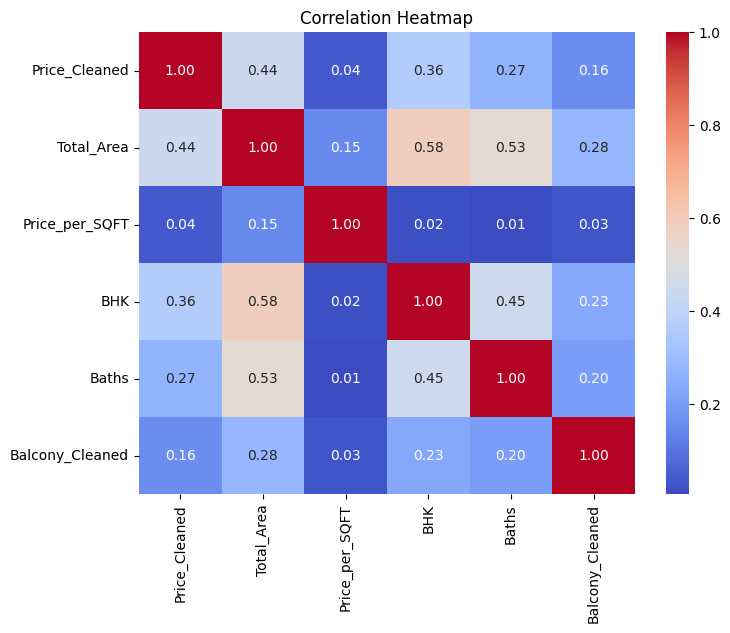

In [19]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
#width 8 height 6
sns.heatmap(df[["Price_Cleaned", "Total_Area", "Price_per_SQFT", "BHK", "Baths", "Balcony_Cleaned"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [21]:
#Features & Target
features = ["Total_Area", "Price_per_SQFT", "Baths", "Balcony_Cleaned", "BHK"]
X = df[features].fillna(df[features].median())
y = df["Price_Cleaned"]

In [22]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
#Train Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [27]:
# Predictions
y_pred = model.predict(X_test)
print(y_pred)

[ 7195239.19112225  6648617.35367694 13480585.18663351 ...
  9826834.05137465 18337999.69003724 11937543.50778093]


In [24]:
#Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\n--- Model Performance ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
#MAE: Average error (in lakhs or crores).
#RMSE: Penalizes larger errors more.
#R² Score: Goodness of fit (closer to 1 = better).


--- Model Performance ---
MAE: 5724448.32
RMSE: 11865432.85
R² Score: 0.2818


In [26]:
#Save Results to CSV
results = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R2 Score"],
    "Value": [mae, rmse, r2]
})

results.to_csv("linear_regression_results.csv", index=False)

print("✅ Results saved to 'linear_regression_results.csv'")

✅ Results saved to 'linear_regression_results.csv'
